In [32]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import statsmodels
from statsmodels.stats.inter_rater import fleiss_kappa

feature_names = np.loadtxt('/Users/borosabel/Documents/Uni/Projects/Bird-Chirping-Classification/Exploration/feature_names.txt', dtype=str).T
root_dir = "/Users/borosabel/Documents/Uni/Projects/Bird-Chirping-Classification/python"
labels = {'cowpig1':2, 'eueowl1':4, 'tawowl1':6, 'eucdov':3, 'grswoo':5, 'comcuc':1, 'other':0}
directories = ['cowpig1', 'eueowl1', 'tawowl1', 'eucdov', 'grswoo', 'comcuc']

sns.set_palette("Paired")

In [29]:
# Utility Functions
def get_all_feature_files_path(directory_path):
    # Get a list of all the feature files path in the directory
    file_names = os.listdir(directory_path)
    file_paths = [os.path.join(directory_path, file_name) for file_name in file_names if '.labels' not in file_name]
    file_paths = [file_path for file_path in file_paths if os.path.isfile(file_path)]
    return file_paths

def get_all_label_files_path(directory_path):
    # Get a list of all the label files path in the directory
    file_names = os.listdir(directory_path)
    file_paths = [os.path.join(directory_path, file_name) for file_name in file_names if '.labels' in file_name]
    file_paths = [file_path for file_path in file_paths if os.path.isfile(file_path)]
    return file_paths

def get_all_files_from_all_dir():
    cowpig_data, cowpig_label = get_all_files_from_dir(['cowpig1'])
    eueowl1_data, eueowl1_label = get_all_files_from_dir(['eueowl1'])
    tawowl1_data, tawowl1_label = get_all_files_from_dir(['tawowl1'])
    eucdov_data, eucdov_label = get_all_files_from_dir(['eucdov'])
    grswoo_data, grswoo_label = get_all_files_from_dir(['grswoo'])
    comcuc_data, comcuc_label = get_all_files_from_dir(['comcuc'])

    all_data = np.concatenate((cowpig_data, eueowl1_data, tawowl1_data, eucdov_data, grswoo_data, comcuc_data))
    all_labels = np.concatenate((cowpig_label, eueowl1_label, tawowl1_label, eucdov_label, grswoo_label, comcuc_label))

    return all_data, all_labels

def get_all_files_from_dir(directory):
    # Get the current directory path

    feature_file_paths = []
    label_file_paths = []
    for dir_ in directory:
        current_dir = root_dir + '/' + dir_
        feature_file_paths = get_all_feature_files_path(current_dir)
        label_file_paths = get_all_label_files_path(current_dir)
        all_files_in_dir = np.empty((0, 548))
        all_labels_in_dir = np.empty((0, 1))

        for file in feature_file_paths:
            label_file = current_dir + '/' + file.split('/')[-1][:-4] + '.labels.npy'
            data = np.load(file)
            labels = np.load(label_file)
            all_files_in_dir = np.concatenate((all_files_in_dir, data))
            all_labels_in_dir = np.concatenate((all_labels_in_dir, labels[:, :1]))

        X = pd.DataFrame(all_files_in_dir, columns = feature_names)
        y = pd.DataFrame(all_labels_in_dir, columns=["label"])

    return X, y

def percentage_agreement(annotations):
    """
    This function calculates the percentage of cases when all the annotators agreed on the same label.
    """
    annotations = annotations[:,1:] #Cut out the majority vote
    total_cases = annotations.shape[0]
    matching_cases = np.sum(np.all(annotations == annotations[:,[0]], axis=1))
    percentage_agreement = matching_cases / total_cases * 100
    return percentage_agreement

def process_annotations(annotations):
    num_annotators = annotations.shape[1]
    num_items = annotations.shape[0]
    num_labels = 2
    M = np.zeros((num_items, num_labels))

    for i in range(num_items):
        for j in range(num_annotators):
            annotation = 0 if annotations[i, j] else 1
            M[i, annotation] += 1

    return M

In [30]:
features, labels = get_all_files_from_all_dir()

In [40]:
file_paths_labels = []
file_paths = []
directories = ['cowpig1', 'eueowl1', 'tawowl1', 'eucdov', 'grswoo', 'comcuc']
labels = {'cowpig1':2, 'eueowl1':4, 'tawowl1':6, 'eucdov':3, 'grswoo':5, 'comcuc':1, 'other':0}
agreement_percentages = []

for dir_ in directories:
    current_dir = root_dir + '/' + dir_
    print("Disagreement in the class of " + dir_ + ":")
    file_paths = get_all_label_files_path(current_dir)
    
    agreement_numbers = []
    for file in file_paths:
        data = np.load(file)
        # Cut the aggregated label
        data = data[:, 1:]
        M = process_annotations(data)
        agreement = fleiss_kappa(M)
#         agreement = percentage_agreement(data[:, 1:])
        if(not np.isnan(agreement)):
            agreement_numbers.append(agreement)
        
    agreement_percentages.append(sum(agreement_numbers) / len(agreement_numbers))
    print(sum(agreement_numbers) / len(agreement_numbers))

Disagreement in the class of cowpig1:
0.6395502372966964
Disagreement in the class of eueowl1:
0.7010410610157463
Disagreement in the class of tawowl1:
0.6392568109460958
Disagreement in the class of eucdov:


/Users/borosabel/lib/python3.9/site-packages/statsmodels/stats/inter_rater.py:267: RuntimeWarning: invalid value encountered in scalar divide
  kappa = (p_mean - p_mean_exp) / (1- p_mean_exp)


0.6464010951488387
Disagreement in the class of grswoo:
0.47677523731525084
Disagreement in the class of comcuc:
0.6700002766329005


In [41]:
agreement_percentages.append(sum(agreement_percentages) / len(agreement_percentages))

In [42]:
directories = ['cowpig1', 'eueowl1', 'tawowl1', 'eucdov', 'grswoo', 'comcuc', 'overall']

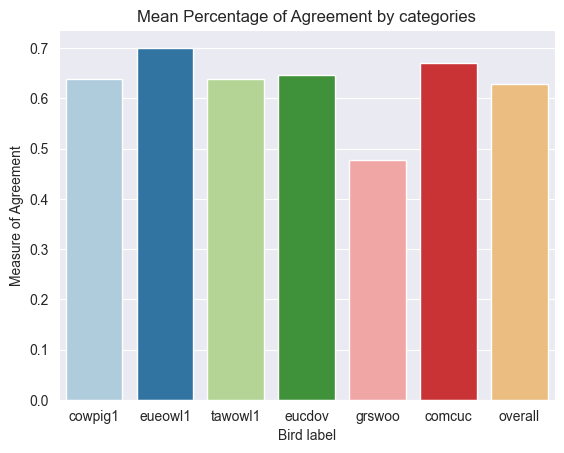

In [43]:
sns.barplot(x=directories, y=agreement_percentages, hue=directories)
plt.title("Mean Percentage of Agreement by categories")
plt.xlabel("Bird label")
plt.ylabel("Measure of Agreement")
plt.show()

So based on this evaluation table: https://miro.medium.com/v2/resize:fit:720/format:webp/1*mHB6Ciljb4OnOacNWgc0aw.png![image.png](attachment:image.png)